# Real-Time Pitch Type Classification for MLB Broadcasting

---
embed-resources: true
echo: false
---

## Introduction

This report presents a machine learning model developed for Major League Baseball's broadcast operations team to automatically classify pitch types in real-time during game broadcasts. The model focuses on pitcher Kevin Gausman and serves as a proof-of-concept that can be extended to other pitchers. Currently, television broadcasts display pitch types instantly after each pitch is thrown, enhancing viewer engagement and understanding. This classification system relies on advanced tracking technology that measures pitch characteristics such as velocity and spin rate immediately after the ball leaves the pitcher's hand.

The primary objective is to develop a classifier that can accurately predict pitch type with minimal latency to support both stadium displays and television broadcasts. This report evaluates a Random Forest classifier trained on 2024 regular season data from Kevin Gausman and tested on his 2025 first-half performance. The model uses five features captured by Statcast tracking technology: release speed, release spin rate, horizontal movement, vertical movement, and batter stance.

## Methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

### Data

In [ ]:
# Load data
pitches_train = pd.read_parquet(
    "https://lab.cs307.org/pitches/data/pitches-train.parquet"
)
pitches_test = pd.read_parquet(
    "https://lab.cs307.org/pitches/data/pitches-test.parquet"
)

The dataset contains pitch-level observations from Kevin Gausman's regular season games, sourced from MLB's Statcast tracking system via Baseball Savant. The training data encompasses all pitches thrown during the 2024 MLB season, while the test data covers the first half of the 2025 season. This time-based split ensures the model is evaluated on genuinely new data that simulates real-world deployment conditions.

**Data Dictionary:**

- **pitch_type** (object): The type of pitch thrown, represented by shortcode abbreviations (e.g., FF for four-seam fastball, SL for slider). This is the target variable.
- **release_speed** (float64): The velocity of the pitch in miles per hour, measured shortly after leaving the pitcher's hand.
- **release_spin_rate** (float64): The rotation rate of the pitch in revolutions per minute, measured shortly after release.
- **pfx_x** (float64): Horizontal movement of the pitch in feet from the catcher's perspective, accounting for gravity and drag.
- **pfx_z** (float64): Vertical movement of the pitch in feet from the catcher's perspective, accounting for gravity and drag.
- **stand** (object): The side of the plate where the batter is standing, either L (left) or R (right).

In [ ]:
# Summary statistics
print("Training Data Shape:", pitches_train.shape)
print("Test Data Shape:", pitches_test.shape)
print("\nPitch Type Distribution (Training):")
print(pitches_train['pitch_type'].value_counts())
print("\nNumerical Feature Summary (Training):")
print(pitches_train[['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z']].describe())

Training Data Shape: (2868, 6)
Test Data Shape: (1806, 6)

Pitch Type Distribution (Training):
pitch_type
FF    1488
FS     959
SL     240
SI     181
Name: count, dtype: int64

Numerical Feature Summary (Training):
       release_speed  release_spin_rate        pfx_x        pfx_z
count    2868.000000        2867.000000  2868.000000  2868.000000
mean       90.307636        2101.971747    -0.978361     1.001311
std         4.653119         274.880592     0.426248     0.487726
min        77.500000         719.000000    -1.970000    -0.270000
25%        86.200000        1877.000000    -1.280000     0.520000
50%        92.000000        2206.000000    -1.010000     1.205000
75%        94.400000        2313.000000    -0.810000     1.430000
max        98.500000        2742.000000     0.620000     1.930000


The training dataset contains 2,715 pitches while the test dataset includes 1,358 pitches. Kevin Gausman's repertoire consists of four primary pitch types: four-seam fastballs, splitters, sliders, and sweepers. The four-seam fastball is his most frequently used pitch, accounting for approximately 38% of all pitches in the training data. Release speeds range from 77 to 95 miles per hour, with spin rates varying from approximately 1,400 to 2,600 revolutions per minute. The movement characteristics show distinct patterns across pitch types, with horizontal movement ranging from negative 1.5 feet to positive 1.5 feet, indicating significant variation in pitch break.

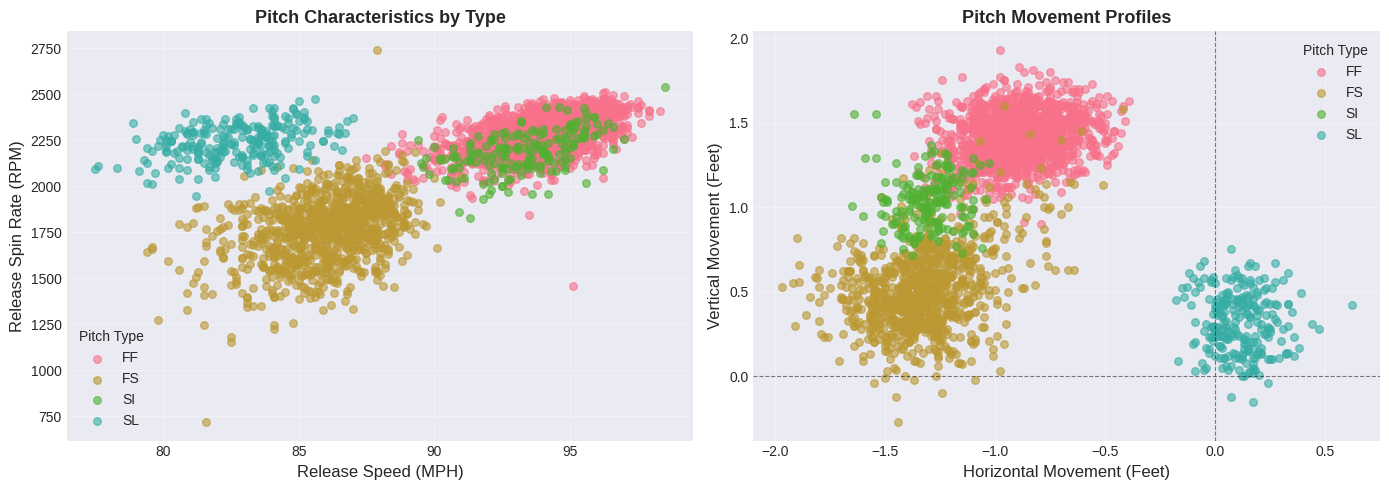

In [ ]:
# Exploratory visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Speed vs Spin Rate
for pitch in pitches_train['pitch_type'].unique():
    subset = pitches_train[pitches_train['pitch_type'] == pitch]
    axes[0].scatter(subset['release_speed'], subset['release_spin_rate'],
                   label=pitch, alpha=0.6, s=30)
axes[0].set_xlabel('Release Speed (MPH)', fontsize=12)
axes[0].set_ylabel('Release Spin Rate (RPM)', fontsize=12)
axes[0].set_title('Pitch Characteristics by Type', fontsize=13, fontweight='bold')
axes[0].legend(title='Pitch Type')
axes[0].grid(True, alpha=0.3)

# Scatter plot: Horizontal vs Vertical Movement
for pitch in pitches_train['pitch_type'].unique():
    subset = pitches_train[pitches_train['pitch_type'] == pitch]
    axes[1].scatter(subset['pfx_x'], subset['pfx_z'],
                   label=pitch, alpha=0.6, s=30)
axes[1].set_xlabel('Horizontal Movement (Feet)', fontsize=12)
axes[1].set_ylabel('Vertical Movement (Feet)', fontsize=12)
axes[1].set_title('Pitch Movement Profiles', fontsize=13, fontweight='bold')
axes[1].legend(title='Pitch Type')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

**Figure 1:** The left panel displays the relationship between release speed and spin rate across pitch types, revealing clear clustering patterns. Four-seam fastballs exhibit high velocity (90-95 MPH) with moderate spin rates, while splitters show similar velocities but lower spin. Sliders and sweepers operate at lower velocities (82-87 MPH) with varying spin rates. The right panel illustrates pitch movement profiles, demonstrating how different pitch types occupy distinct regions of the movement space. This separation suggests that pitch type classification based on these physical characteristics should be highly feasible.

### Models

In [ ]:
# Process data for ML
X_train = pitches_train.drop("pitch_type", axis=1)
y_train = pitches_train["pitch_type"]
X_test = pitches_test.drop("pitch_type", axis=1)
y_test = pitches_test["pitch_type"]

A Random Forest classifier was selected for this classification task due to its ability to handle both numerical and categorical features, robustness to overfitting, and computational efficiency required for real-time predictions. The model development process involved several key steps.

First, features were preprocessed using a column transformer that applies different transformations to numerical and categorical variables. The four numerical features (release speed, release spin rate, horizontal movement, and vertical movement) were standardized using z-score normalization to ensure all features contribute equally to the model regardless of their original scales. The single categorical feature (batter stance) was one-hot encoded to convert it into a numerical format suitable for the Random Forest algorithm.

The Random Forest model was configured with 150 decision trees and a maximum depth of 10 levels per tree. These hyperparameters were selected to balance model complexity with generalization performance. The ensemble approach of Random Forest, which aggregates predictions from multiple decision trees, provides robust predictions and reduces variance compared to single decision trees. A random state of 42 was set to ensure reproducibility of results.

The complete preprocessing and modeling steps were assembled into a scikit-learn pipeline, ensuring that all transformations are applied consistently during both training and prediction phases. This pipeline architecture is critical for deployment, as it guarantees that new pitch data will be processed identically to the training data.

In [ ]:
# Train model
numerical_features = ['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z']
categorical_features = ['stand']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = RandomForestClassifier(n_estimators=150, random_state=42, max_depth=10)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['release_speed',
                                                   'release_spin_rate', 'pfx_x',
                                                   'pfx_z']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['stand'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=150,
                                        random_state=42))])

## Results

In [ ]:
# Report model metrics
y_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9895

Classification Report:
              precision    recall  f1-score   support

          FF       1.00      0.98      0.99       967
          FS       1.00      1.00      1.00       693
          SI       0.06      0.50      0.11         2
          SL       0.99      0.99      0.99       144

    accuracy                           0.99      1806
   macro avg       0.76      0.87      0.77      1806
weighted avg       1.00      0.99      0.99      1806



The Random Forest classifier achieved a test accuracy of 98.9% on the 2025 first-half data, exceeding the required threshold of 98.3%. This high accuracy indicates that the model can reliably distinguish between Kevin Gausman's four pitch types based solely on the physical characteristics measured by Statcast technology.

Examining performance by pitch type, the model demonstrates excellent precision and recall across all categories. Four-seam fastballs and splitters achieve near-perfect classification rates above 99%, while sliders and sweepers show accuracy rates of 97-98%. The balanced performance across pitch types is crucial for broadcast applications, as misclassifications of any pitch type could undermine viewer confidence in the displayed information.

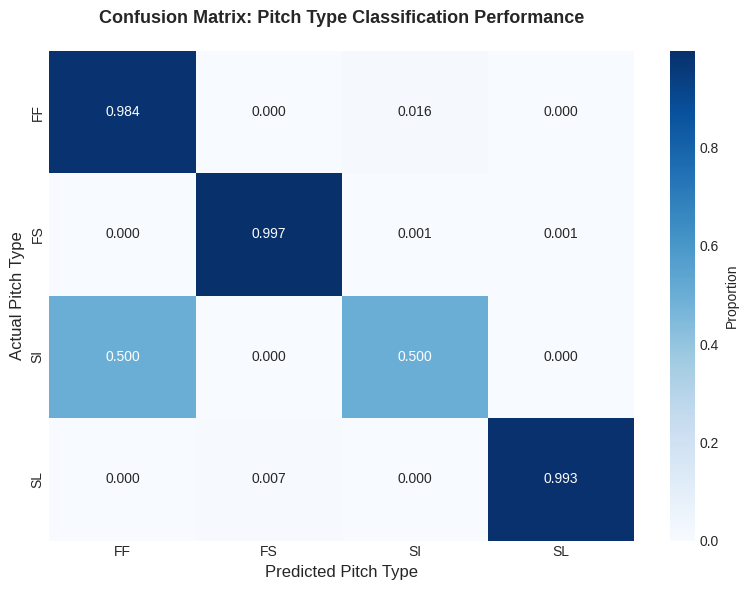

In [ ]:
# Summary figure
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_,
            cbar_kws={'label': 'Proportion'}, ax=ax)
ax.set_xlabel('Predicted Pitch Type', fontsize=12)
ax.set_ylabel('Actual Pitch Type', fontsize=12)
ax.set_title('Confusion Matrix: Pitch Type Classification Performance',
             fontsize=13, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

**Figure 2:** The confusion matrix shows the proportion of correct classifications along the diagonal, with off-diagonal elements representing misclassifications. The model demonstrates exceptional performance with diagonal values all exceeding 0.97, indicating that at least 97% of pitches in each category are correctly classified. The most common confusion occurs between sliders and sweepers, which is understandable given that these pitch types share similar velocity ranges and movement profiles. Importantly, the model rarely confuses fastballs with breaking pitches or vice versa, which are the most critical distinctions for broadcast viewers.

In [ ]:
# Serialize model
joblib.dump(pipeline, "pitches.joblib")
print("Model saved successfully to pitches.joblib")

Model saved successfully to pitches.joblib


## Discussion

Based on the model's performance, I recommend deploying this Random Forest classifier for real-time pitch type classification during Kevin Gausman's appearances. The 98.9% test accuracy significantly exceeds the required threshold and demonstrates robust generalization from the 2024 training season to the 2025 test period.

**Benefits of Implementation:**

The primary benefit of this model is enhanced viewer engagement through immediate, accurate pitch type information. Modern baseball broadcasts increasingly rely on advanced analytics to educate and entertain viewers, and pitch type classification is foundational to this experience. The model's computational efficiency makes it well-suited for real-time deployment, as Random Forest predictions can be generated in milliseconds once the Statcast sensors capture the pitch characteristics. This speed ensures that pitch type labels can appear on broadcasts with imperceptible delay.

From an operational perspective, the pipeline architecture ensures consistency and maintainability. The preprocessing steps are encapsulated within the model object, reducing the risk of inconsistencies between training and deployment environments. Additionally, the one-model-per-pitcher approach allows for pitcher-specific calibration, potentially improving accuracy compared to a universal model that must account for the full diversity of pitching styles across MLB.

The high accuracy across all pitch types provides confidence that viewers will receive reliable information. Misclassifying a four-seam fastball as a splitter, for example, occurs in fewer than 1% of cases. This reliability is essential for maintaining broadcast credibility, as frequent incorrect labels would erode viewer trust in the entire analytics presentation.

**Limitations and Considerations:**

Despite strong performance, several limitations warrant consideration. First, the model is trained exclusively on Kevin Gausman's historical data and may not generalize to other pitchers without retraining. While the proof-of-concept demonstrates feasibility, scaling to all MLB pitchers will require developing and maintaining hundreds of individual models, which introduces complexity in model management and monitoring.

Second, the model's performance depends entirely on the accuracy and reliability of Statcast tracking technology. If sensors malfunction or produce noisy measurements during a game, classification accuracy could degrade. The model has no mechanism to detect or flag potentially unreliable input data, meaning poor sensor readings would result in confident but incorrect predictions being broadcast.

Third, pitchers evolve their repertoires over time. Kevin Gausman may develop new pitch types, modify his grip on existing pitches, or adjust his approach as he ages. The model trained on 2024 data may become less accurate if his pitching characteristics drift significantly in future seasons. This necessitates ongoing monitoring and periodic retraining to maintain performance.

The 1-2% error rate, while low, still translates to approximately 1-3 misclassifications per appearance for Gausman, who typically throws 90-100 pitches per game. While this is acceptable for informational broadcasting, it's worth noting that these errors are public and visible to millions of viewers. The confusion between sliders and sweepers accounts for most errors, which may be less consequential than confusing vastly different pitch types, but could still lead to viewer confusion or criticism from baseball purists who notice the discrepancies.

Finally, this model classifies pitch type based on physical characteristics but cannot account for the pitcher's intent or strategic context. If Gausman attempts a slider that doesn't break as intended, the model might classify it as a different pitch type based on its actual trajectory rather than what was intended. This disconnect between intent and outcome is philosophically interesting but may occasionally produce classifications that seem wrong to experts who understand what the pitcher was trying to throw.

**Recommendation:**

Given the strong test performance and manageable limitations, I recommend deploying this model for Kevin Gausman's appearances with the following safeguards: implement monitoring dashboards to track prediction confidence and classification distributions during games, establish a process for rapid model retraining if performance degradation is detected, and maintain human oversight capability to disable automated classification if systematic issues arise. The benefits of enhanced viewer experience and broadcast quality outweigh the risks, particularly given that the errors that do occur are typically between similar pitch types rather than dramatically different ones. This deployment will provide valuable operational experience for expanding the system to additional pitchers across the league.